In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
%matplotlib inline

### 1a. Print the configuration settings of the PySpark environment

In [3]:
#create Spark session
spark = SparkSession.builder.appName('HW3').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '5g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

23/07/23 18:56:35 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


[('spark.eventLog.enabled', 'true'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.dataproc.sql.joinConditionReorder.enabled', 'true'),
 ('spark.executor.memory', '5g'),
 ('spark.dataproc.metrics.listener.metrics.collector.hostname',
  'cluster-46ec-m'),
 ('spark.hadoop.mapreduce.fileoutputcommitter.concurrent.write.enabled',
  'false'),
 ('spark.app.startTime', '1690138527366'),
 ('spark.dataproc.sql.local.rank.pushdown.enabled', 'true'),
 ('spark.yarn.unmanagedAM.enabled', 'true'),
 ('spark.ui.filters',
  'org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter'),
 ('spark.metrics.namespace',
  'app_name:${spark.app.name}.app_id:${spark.app.id}'),
 ('spark.dataproc.sql.optimizer.leftsemijoin.conversion.enabled', 'true'),
 ('spark.driver.appUIAddress',
  'http://cluster-46ec-m.us-central1-c.c.crack-linker-393718.internal:43243'),
 ('spark.executor.id', 'driver'),
 ('spark.hadoop.hive.execution.engine', 'mr'),
 ('spark.ui.proxyBase', '/proxy/application_1690137476125_0003

### 1b. Read the Chicago crimes dataset into a PySpark dataframe

In [31]:
df = spark.read \
    .option("quote", "\"")  \
    .option("escape", "\"") \
    .option("ignoreLeadingWhiteSpace",True) \
    .csv("gs://bdp-hw-su/notebooks/data/Crimes_-_2001_to_Present.csv",inferSchema=True, header=True)

In [5]:
df.take(1)

[Row(ID=11646166, Case Number='JC213529', Date='09/01/2018 12:01:00 AM', Block='082XX S INGLESIDE AVE', IUCR='0810', Primary Type='THEFT', Description='OVER $500', Location Description='RESIDENCE', Arrest=False, Domestic=True, Beat=631, District=6, Ward=8, Community Area=44, FBI Code='06', X Coordinate=None, Y Coordinate=None, Year=2018, Updated On='04/06/2019 04:04:43 PM', Latitude=None, Longitude=None, Location=None)]

### 1c. Print summary statistics of the data set

In [6]:
df.describe().show()

+-------+------------------+------------------+--------------------+--------------+------------------+-----------------+---------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+----------------+--------------------+--------------------+
|summary|                ID|       Case Number|                Date|         Block|              IUCR|     Primary Type|    Description|Location Description|              Beat|          District|              Ward|    Community Area|          FBI Code|      X Coordinate|      Y Coordinate|              Year|          Updated On|        Latitude|           Longitude|            Location|
+-------+------------------+------------------+--------------------+--------------+------------------+-----------------+---------------+--------------------+------------------+------------------+------------------+------

### 1d. Inspect the data partitions and repartition if needed

In [7]:
#display number of records by partition
def displaypartitions(df):
    #number of records by partition
    num = df.rdd.getNumPartitions()
    print("Partitions:", num)
    df.withColumn("partitionId", F.spark_partition_id())\
        .groupBy("partitionId")\
        .count()\
        .orderBy(F.asc("count"))\
        .show(num)

In [32]:
#number of partitions
df.rdd.getNumPartitions()

14

In [33]:
displaypartitions(df)

Partitions: 14


+-----------+------+
|partitionId| count|
+-----------+------+
|         13|445055|
|          2|559272|
|          3|562798|
|          1|562858|
|         12|565793|
|         10|566343|
|         11|566443|
|          8|566498|
|          7|566513|
|          6|567461|
|          9|567531|
|          5|568943|
|          4|583667|
|          0|588201|
+-----------+------+



In [34]:
#re-partition the data
df = df.repartition(16)
displaypartitions(df)

Partitions: 16


+-----------+------+
|partitionId| count|
+-----------+------+
|         11|489829|
|         10|489831|
|          9|489832|
|          7|489832|
|          8|489832|
|          6|489834|
|          5|489835|
|          4|489836|
|          3|489837|
|          1|489838|
|          2|489838|
|          0|489839|
|         15|489839|
|         14|489840|
|         13|489841|
|         12|489843|
+-----------+------+



### 2a. Drop the columns beat, ward, latitude and longitude columns

In [35]:
df = df.drop("Beat", "Ward", "Latitude", "Longitude")

### 2b. Convert remaining columns to appropriate data types. Make your best assumptions by sampling the data. View schema again to ensure that data types have been converted.

In [36]:
df.take(1)

[Row(ID=12772036, Case Number='JF330609', Date='07/24/2022 02:00:00 AM', Block='067XX W IRVING PARK RD', IUCR='0498', Primary Type='BATTERY', Description='AGG. DOMESTIC BATTERY - HANDS, FISTS, FEET, SERIOUS INJURY', Location Description='APARTMENT', Arrest=True, Domestic=True, District=16, Community Area=17, FBI Code='04B', X Coordinate=1130726, Y Coordinate=1925839, Year=2022, Updated On='01/03/2023 03:46:28 PM', Location='(41.95276886, -87.794846516)')]

In [37]:
df.dtypes

[('ID', 'int'),
 ('Case Number', 'string'),
 ('Date', 'string'),
 ('Block', 'string'),
 ('IUCR', 'string'),
 ('Primary Type', 'string'),
 ('Description', 'string'),
 ('Location Description', 'string'),
 ('Arrest', 'boolean'),
 ('Domestic', 'boolean'),
 ('District', 'int'),
 ('Community Area', 'int'),
 ('FBI Code', 'string'),
 ('X Coordinate', 'int'),
 ('Y Coordinate', 'int'),
 ('Year', 'int'),
 ('Updated On', 'string'),
 ('Location', 'string')]

In [38]:
df = df.withColumn("ID",F.col("ID").cast("string"))

In [39]:
df = df.withColumn('Date', F.to_timestamp('Date', 'MM/dd/yyyy hh:mm:ss a')) \
       .withColumn('Updated On', F.to_timestamp('Updated On', 'MM/dd/yyyy hh:mm:ss a'))

In [40]:
df = df.withColumn("District",F.col("District").cast("string")) \
    .withColumn("Community Area",F.col("Community Area").cast("string"))

In [41]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- District: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: timestamp (nullable = true)
 |-- Location: string (nullable = true)



In [42]:
# Check the success of conversion
df.select('Date').show(10)

+-------------------+
|               Date|
+-------------------+
|2018-01-24 16:20:00|
|2018-10-18 15:15:00|
|2017-04-23 19:00:00|
|2018-02-16 21:30:00|
|2016-12-31 12:30:00|
|2017-11-12 23:15:00|
|2017-04-13 13:00:00|
|2017-08-03 16:45:00|
|2018-08-04 17:00:00|
|2018-03-31 08:00:00|
+-------------------+
only showing top 10 rows



### 2a.Add a month column and community name (from metadata) to the dataset

In [43]:
from pyspark.sql.functions import month
df = df.withColumn("Month",month(df['Date']))

In [44]:
# Check the success of conversion
df.select('Month').show(10)

+-----+
|Month|
+-----+
|    7|
|   12|
|    4|
|    8|
|    2|
|   11|
|   10|
|    2|
|    1|
|    5|
+-----+
only showing top 10 rows



In [54]:
# loading a community names data from kaggle
names = spark.read \
    .option("quote", "\"")  \
    .option("escape", "\"") \
    .option("delimiter",";") \
    .option("ignoreLeadingWhiteSpace",True) \
    .csv("gs://bdp-hw-su/notebooks/data/chicago_area.csv",inferSchema=True, header=True)

In [55]:
names.dtypes

[('dropoff_community_area', 'int'), ('community_name', 'string')]

In [56]:
names = names.withColumn("dropoff_community_area",F.col("dropoff_community_area").cast("string"))

In [57]:
names =  names.selectExpr(
    'dropoff_community_area AS `Community Area`',
    'community_name AS `Community Name`'
)

In [58]:
names.dtypes

[('Community Area', 'string'), ('Community Name', 'string')]

In [60]:
df = df.join(names, df["Community Area"]== names["Community Area"])

In [61]:
df.take(1)

[Row(ID='2121327', Case Number='HH329041', Date=datetime.datetime(2002, 4, 24, 21, 55), Block='061XX S CHAMPLAIN AVE', IUCR='2024', Primary Type='NARCOTICS', Description='POSS: HEROIN(WHITE)', Location Description='SIDEWALK', Arrest=True, Domestic=False, District='3', Community Area='42', FBI Code='18', X Coordinate=1181622, Y Coordinate=1864542, Year=2002, Updated On=datetime.datetime(2018, 2, 10, 15, 50, 1), Location='(41.783536746, -87.609650728)', Month=4, Community Area='42', Community Name='Woodlawn')]

### 3a. Group and count crimes where description begins with the word “aggravated”

In [76]:
df.where(F.col("Description").like("AGGRAVATED%")) \
.groupBy('Description').agg(F.count('*').alias('Count')).show()

+--------------------+-----+
|         Description|Count|
+--------------------+-----+
|AGGRAVATED PO:KNI...|  545|
|AGGRAVATED: OTHER...|83818|
|AGGRAVATED DOMEST...| 1982|
|AGGRAVATED POLICE...|  207|
|AGGRAVATED DOMEST...|  136|
|AGGRAVATED DOMEST...| 3553|
|AGGRAVATED FINANC...| 1036|
|AGGRAVATED: OTHER...| 2701|
| AGGRAVATED: HANDGUN|78733|
|AGGRAVATED PO: OT...|   93|
|AGGRAVATED DOMEST...|13508|
|AGGRAVATED:KNIFE/...|52116|
|AGGRAVATED POLICE...|   49|
|AGGRAVATED - HAND...|  452|
|   AGGRAVATED: OTHER| 4103|
|AGGRAVATED POLICE...|  428|
|AGGRAVATED VEHICU...|12647|
|AGGRAVATED POLICE...|  377|
|AGGRAVATED - HANDGUN|24973|
|AGGRAVATED SEXUAL...| 1149|
+--------------------+-----+
only showing top 20 rows



### 3b. Which crime type is the most prevalent in apartments and which community has it occurred the most

In [77]:
apt_crime = df.where(F.col("Location Description").like("APARTMENT%"))

In [80]:
apt_crime.groupBy('Primary Type').agg(F.count('*').alias('Count')).sort(F.desc('Count')).show()

+--------------------+------+
|        Primary Type| Count|
+--------------------+------+
|             BATTERY|288875|
|            BURGLARY|118163|
|     CRIMINAL DAMAGE| 95807|
|               THEFT| 91529|
|       OTHER OFFENSE| 77506|
|             ASSAULT| 68211|
|  DECEPTIVE PRACTICE| 36009|
|   CRIMINAL TRESPASS| 16990|
|OFFENSE INVOLVING...| 13522|
|           NARCOTICS| 13099|
| CRIM SEXUAL ASSAULT|  6633|
|   WEAPONS VIOLATION|  5309|
|             ROBBERY|  5182|
|         SEX OFFENSE|  4425|
|CRIMINAL SEXUAL A...|  2303|
|PUBLIC PEACE VIOL...|  2171|
| MOTOR VEHICLE THEFT|  1516|
|               ARSON|  1070|
|            HOMICIDE|  1044|
|            STALKING|   804|
+--------------------+------+
only showing top 20 rows



In [81]:
apt_crime.groupBy('Community Name').agg(F.count('*').alias('Count')).sort(F.desc('Count')).show()

+--------------------+-----+
|      Community Name|Count|
+--------------------+-----+
|         South Shore|65652|
|              Austin|61874|
|Greater Grand Cro...|34375|
|      North Lawndale|31981|
|           Englewood|30568|
|      Auburn Gresham|29492|
|             Chatham|28329|
|       Humboldt Park|27255|
|            Woodlawn|27097|
|         Rogers Park|23176|
|        Chicago Lawn|21640|
|       South Chicago|21336|
|           West Town|20447|
|      West Englewood|19570|
|        Logan Square|19039|
|            New City|17177|
|  East Garfield Park|16968|
|     Washington Park|16908|
|  West Garfield Park|16600|
|          West Ridge|15843|
+--------------------+-----+
only showing top 20 rows



South Shore and Austin had the most apartment crimes.

### 3c. What is the maximum number of weapons violations per month that occurred in 2020.

In [82]:
df.groupBy('Primary Type').agg(F.count('*').alias('Count')).sort(F.desc('Count')).show()

+--------------------+-------+
|        Primary Type|  Count|
+--------------------+-------+
|               THEFT|1531488|
|             BATTERY|1313733|
|     CRIMINAL DAMAGE| 821792|
|           NARCOTICS| 681273|
|             ASSAULT| 472135|
|       OTHER OFFENSE| 447078|
|            BURGLARY| 393295|
| MOTOR VEHICLE THEFT| 348496|
|  DECEPTIVE PRACTICE| 330886|
|             ROBBERY| 270927|
|   CRIMINAL TRESPASS| 197970|
|   WEAPONS VIOLATION| 102775|
|        PROSTITUTION|  61856|
|OFFENSE INVOLVING...|  53586|
|PUBLIC PEACE VIOL...|  49105|
|         SEX OFFENSE|  28410|
| CRIM SEXUAL ASSAULT|  25542|
|INTERFERENCE WITH...|  17990|
|            GAMBLING|  13496|
|LIQUOR LAW VIOLATION|  12927|
+--------------------+-------+
only showing top 20 rows



In [85]:
weapon = df.where(F.col("Primary Type").like("WEAPON%") & F.col("Year").like('2020'))

In [86]:
weapon.show()

+--------+-----------+-------------------+--------------------+----+-----------------+--------------------+--------------------+------+--------+--------+--------------+--------+------------+------------+----+-------------------+--------------------+-----+--------------+------------------+
|      ID|Case Number|               Date|               Block|IUCR|     Primary Type|         Description|Location Description|Arrest|Domestic|District|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|         Updated On|            Location|Month|Community Area|    Community Name|
+--------+-----------+-------------------+--------------------+----+-----------------+--------------------+--------------------+------+--------+--------+--------------+--------+------------+------------+----+-------------------+--------------------+-----+--------------+------------------+
|12124424|   JD319232|2020-08-03 04:28:00| 032XX N CENTRAL AVE|1477|WEAPONS VIOLATION|RECKLESS FIREARM ...|COMMERCIAL / BUSI...| f

In [87]:
weapon.groupBy("Month").agg(F.count("*").alias("Count")).sort(F.desc("Count")).show()

+-----+-----+
|Month|Count|
+-----+-----+
|    8|  985|
|    9|  831|
|   10|  806|
|    7|  804|
|    5|  792|
|    6|  783|
|   11|  777|
|   12|  765|
|    1|  490|
|    4|  474|
|    3|  464|
|    2|  461|
+-----+-----+



In 2020, summer months had the most crimes related to weapons.

### 3d. What percentage of the domestic crimes led to an arrest ?

In [90]:
df.filter(F.col('Domestic') == True).groupBy('Arrest').agg(F.count('*').alias('Count')).show()

+------+------+
|Arrest| Count|
+------+------+
|  true|188763|
| false|821234|
+------+------+



In [92]:
import numpy as np
print(np.round(188763 / (188763+821234) *100,2), '% of the domestic crimes led to an arrest.')

18.69 % of the domestic crimes led to an arrest.


### 4a. Which day of the week and which month have the most and the least crimes on average

In [93]:
df = df.withColumn('day', F.dayofweek('Date'))

In [95]:
df.show(4)

+--------+-----------+-------------------+--------------------+----+---------------+--------------+--------------------+------+--------+--------+--------------+--------+------------+------------+----+-------------------+--------------------+-----+--------------+---------------+---+
|      ID|Case Number|               Date|               Block|IUCR|   Primary Type|   Description|Location Description|Arrest|Domestic|District|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|         Updated On|            Location|Month|Community Area| Community Name|day|
+--------+-----------+-------------------+--------------------+----+---------------+--------------+--------------------+------+--------+--------+--------------+--------+------------+------------+----+-------------------+--------------------+-----+--------------+---------------+---+
|10513938|   HZ255678|2016-05-07 22:00:00|    005XX W SCOTT ST|1320|CRIMINAL DAMAGE|    TO VEHICLE|             TAXICAB| false|   false|      18|      

In [101]:
df.groupBy('day').agg(F.count('*').alias('Count')).sort(F.desc('Count')).show()

+---+-------+
|day|  Count|
+---+-------+
|  6|1085172|
|  4|1038447|
|  7|1035226|
|  3|1031977|
|  5|1027993|
|  2|1019747|
|  1| 985262|
+---+-------+



The numbering system of dayofweek function is 1=Sunday, 7=Saturday. It appears that Fridays have the most crime. Sundays have the least.

In [98]:
df.groupBy('Month').agg(F.count('*').alias('Count')).sort(F.desc('Count')).show()

+-----+------+
|Month| Count|
+-----+------+
|    7|674189|
|    8|666746|
|    5|663125|
|    6|662085|
|   10|633654|
|    9|627093|
|    4|581832|
|    3|573067|
|   11|569810|
|    1|547576|
|   12|543410|
|    2|481237|
+-----+------+



July has the most crime. February tend to have the least.

### 4b.Which date had the most number of homicides in the dataset. How many days passed between this date and the next highest number of homicides

In [102]:
homicides = df.where(F.col("Primary Type").like("HOMICIDE%"))

In [105]:
h_bydate = homicides.groupBy(F.date_format('Date', 'MM/dd/yyyy').alias('date')).agg(F.count('*').alias('Count')).sort(F.desc('Count'))

In [106]:
h_bydate.show()

+----------+-----+
|      date|Count|
+----------+-----+
|05/31/2020|   19|
|09/02/2015|   10|
|07/05/2003|   10|
|05/27/2023|   10|
|09/05/2016|    9|
|02/04/2016|    9|
|06/15/2021|    9|
|07/04/2020|    9|
|04/04/2021|    8|
|11/07/2021|    8|
|06/28/2020|    8|
|08/05/2018|    8|
|08/23/2016|    8|
|08/13/2017|    8|
|07/14/2017|    8|
|09/27/2021|    8|
|06/18/2017|    8|
|07/05/2017|    8|
|04/07/2020|    8|
|10/23/2022|    8|
+----------+-----+
only showing top 20 rows



In [128]:
datediff = spark.createDataFrame([('2020-05-31', '2015-09-02')], ['date1', 'date2'])

datediff = datediff.withColumn('date1', F.to_date('date1')).withColumn('date2', F.to_date('date2'))

datediff = datediff.withColumn('diff', F.datediff('date1', 'date2'))

In [129]:
datediff.show()

+----------+----------+----+
|     date1|     date2|diff|
+----------+----------+----+
|2020-05-31|2015-09-02|1733|
+----------+----------+----+



The date difference between these two dates is 1733. However, there are two other dates with the same number of homicides.

### 4c. Plot a monthly time series line chart of all crimes for the last 3 years

In [136]:
past3yrs = df.filter(F.col('Year')>=2020)

past3yrs = past3yrs.groupBy([F.col('Year'), F.col('Month')]).agg(F.count('*').alias('count')).orderBy('Year','Month')

In [137]:
past3yrs.show(3)

+----+-----+-----+
|Year|Month|count|
+----+-----+-----+
|2020|    1|19932|
|2020|    2|18197|
|2020|    3|16750|
+----+-----+-----+
only showing top 3 rows



In [139]:
threeyrdf = past3yrs.toPandas()

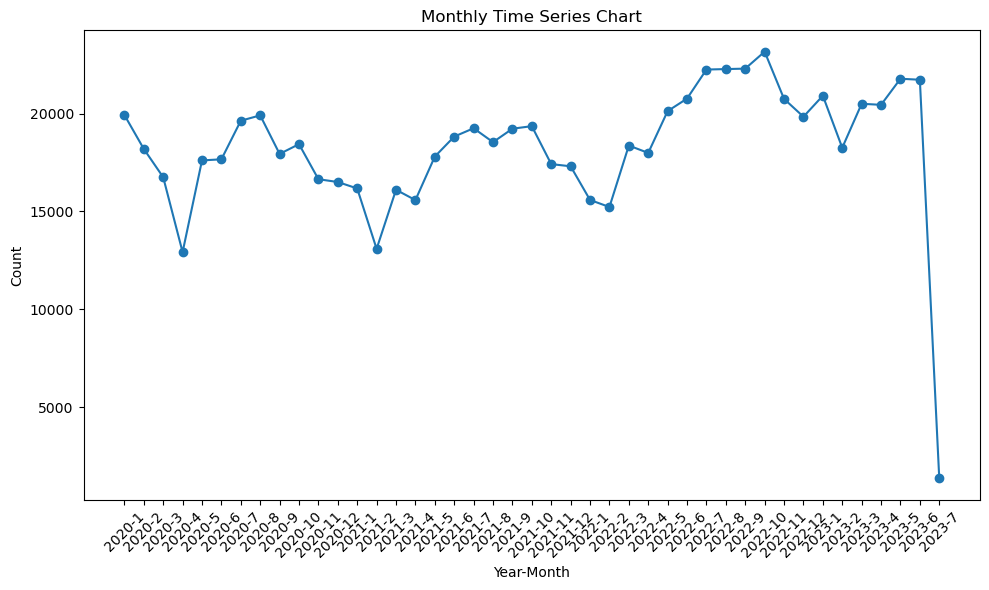

In [142]:
# Plot the time series chart
plt.figure(figsize=(10, 6))
plt.plot(threeyrdf["Year"].astype(str) + "-" + threeyrdf["Month"].astype(str), threeyrdf["count"], marker='o')
plt.xlabel("Year-Month")
plt.ylabel("Count")
plt.title("Monthly Time Series Chart")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 4d. Plot a year over year comparison for 3 years (2020, 2021, 2022) by top 5 crime types.

In [144]:
df.groupBy('Primary Type').agg(F.count('*').alias('Count')).sort(F.desc('Count')).take(5)

[Row(Primary Type='THEFT', Count=1531488),
 Row(Primary Type='BATTERY', Count=1313733),
 Row(Primary Type='CRIMINAL DAMAGE', Count=821792),
 Row(Primary Type='NARCOTICS', Count=681273),
 Row(Primary Type='ASSAULT', Count=472135)]

In [153]:
top5 = df.filter(F.col('Primary Type').isin("THEFT", "BATTERY", "CRIMINAL DAMAGE", "NARCOTICS", "ASSAULT") & F.col('Year').between(2020,2022))  \
                 .groupBy("Year", 'Primary Type').agg(F.count("*").alias('Count'))

In [154]:
top5df = top5.toPandas()

In [155]:
top5df

,Year,Primary Type,Count
0,2022,ASSAULT,20788
1,2022,BATTERY,40896
2,2022,NARCOTICS,4716
3,2021,ASSAULT,20342
4,2021,THEFT,40794
5,2020,CRIMINAL DAMAGE,24878
6,2020,THEFT,41320
7,2020,BATTERY,41512
8,2021,BATTERY,40457
9,2022,THEFT,54798


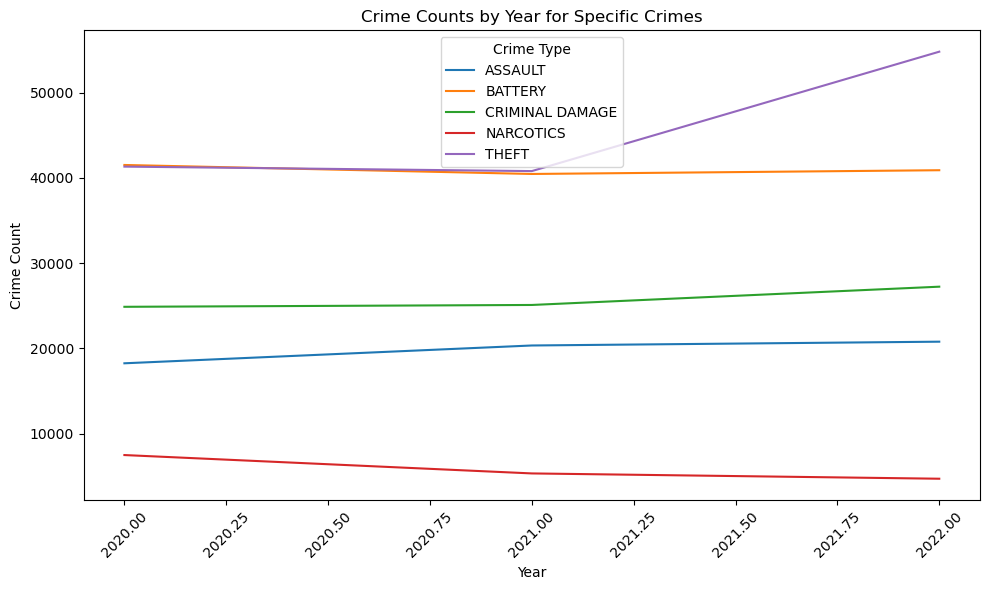

In [157]:
# Pivot the data to get the crimes as columns and years as rows
pivoted_df = top5df.pivot(index='Year', columns='Primary Type', values='Count')

# Plot the line chart
pivoted_df.plot(kind='line', figsize=(10, 6))
plt.xlabel("Year")
plt.ylabel("Crime Count")
plt.title("Crime Counts by Year for Specific Crimes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Crime Type")
plt.show()

### 5a. Use a window function to calculate the community rank based on total crime figures (highest to lowest), where the community with the highest crime will have rank 1. Your results set should have 1 row for each community, with a column for the community name and the rank. You can also add a column with the total crime count if it helps you.

In [165]:
from pyspark.sql import Window
window = Window.orderBy(F.desc("Count"))

ranks = df.groupBy("Community Name").count()

In [166]:

 # applying the rank() function
ranks.withColumn("rank", F.rank().over(window)) \
    .show()

23/07/23 22:16:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/07/23 22:16:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/07/23 22:16:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/07/23 22:16:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/07/23 22:16:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/07/23 22:16:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/07/23 2

+--------------------+------+----+
|      Community Name| count|rank|
+--------------------+------+----+
|              Austin|450972|   1|
|     Near North Side|254892|   2|
|         South Shore|238241|   3|
|       Humboldt Park|225331|   4|
|      Near West Side|219048|   5|
|           West Town|211793|   6|
|      North Lawndale|211425|   7|
|      West Englewood|206067|   8|
|      Auburn Gresham|204554|   9|
|            Roseland|191815|  10|
|           Englewood|188229|  11|
|Greater Grand Cro...|179584|  12|
|                Loop|179424|  13|
|        Chicago Lawn|175515|  14|
|             Chatham|159261|  15|
|        Logan Square|149310|  16|
|           Lake View|146158|  17|
|            New City|145298|  18|
|  West Garfield Park|136365|  19|
|  East Garfield Park|135163|  20|
+--------------------+------+----+
only showing top 20 rows



### 5b. Use a window function to calculate a rolling 7 day sum of crimes over time within each community Your results set should have 3 columns: community, date, and the rolling/lagging 7 day sum.

In [171]:

df1 = df.withColumn('Date', F.date_format(F.col('Date'), 'yyyy-MM-dd'))

window = Window.partitionBy('Community Name').orderBy('Date').rowsBetween(-6,0)

rolling = df1.groupBy('Community Name', 'Date').count()

In [173]:
rolling = rolling.withColumn('Rolling 7-Day Sum', F.sum(F.col('count')).over(window))

rolling = rolling.drop('count')

rolling.show()

+--------------+----------+-----------------+
|Community Name|      Date|Rolling 7-Day Sum|
+--------------+----------+-----------------+
|       Ashburn|2001-01-01|                4|
|       Ashburn|2001-01-25|                5|
|       Ashburn|2001-02-01|                6|
|       Ashburn|2001-02-13|                7|
|       Ashburn|2001-02-21|                8|
|       Ashburn|2001-02-23|                9|
|       Ashburn|2001-03-16|               10|
|       Ashburn|2001-04-23|                7|
|       Ashburn|2001-05-09|                7|
|       Ashburn|2001-05-27|                7|
|       Ashburn|2001-06-21|                7|
|       Ashburn|2001-06-30|                7|
|       Ashburn|2001-07-01|                7|
|       Ashburn|2001-07-30|                7|
|       Ashburn|2001-08-01|                7|
|       Ashburn|2001-08-04|                7|
|       Ashburn|2001-08-09|                7|
|       Ashburn|2001-09-01|                9|
|       Ashburn|2001-09-24|       

### 5c. Use window functions to calculate a 7 day moving average and cumulative sum of crimes over time within each community. Your results set should have 4 columns: community, date, the 7 day moving average, and the cumulative sum.

In [180]:
window_avg = Window.partitionBy('Community Name').orderBy('Date').rowsBetween(-6,0)
window_cumsum = Window.partitionBy('Community Name').orderBy("Date").rowsBetween(Window.unboundedPreceding, Window.currentRow)

rolling = df1.groupBy('Community Name', 'Date').count()

In [182]:
rolling = rolling.withColumn('Rolling 7-Day Avg', F.avg(F.col('count')).over(window_avg))
rolling = rolling.withColumn('Cumulative Sum', F.sum('count').over(window_cumsum))

rolling = rolling.drop('count')

rolling.show()

+--------------+----------+------------------+--------------+
|Community Name|      Date| Rolling 7-Day Avg|Cumulative Sum|
+--------------+----------+------------------+--------------+
|       Ashburn|2001-01-01|               4.0|             4|
|       Ashburn|2001-01-25|               2.5|             5|
|       Ashburn|2001-02-01|               2.0|             6|
|       Ashburn|2001-02-13|              1.75|             7|
|       Ashburn|2001-02-21|               1.6|             8|
|       Ashburn|2001-02-23|               1.5|             9|
|       Ashburn|2001-03-16|1.4285714285714286|            10|
|       Ashburn|2001-04-23|               1.0|            11|
|       Ashburn|2001-05-09|               1.0|            12|
|       Ashburn|2001-05-27|               1.0|            13|
|       Ashburn|2001-06-21|               1.0|            14|
|       Ashburn|2001-06-30|               1.0|            15|
|       Ashburn|2001-07-01|               1.0|            16|
|       

### 5d. Cross-tabulate Crime Types vs Location description and visualize it through a heatmap

In [189]:
crosstab = df.groupBy('Primary Type', 'Location Description').count().toPandas()

In [190]:
import seaborn as sns
crosstab = crosstab.pivot('Primary Type','Location Description','count')



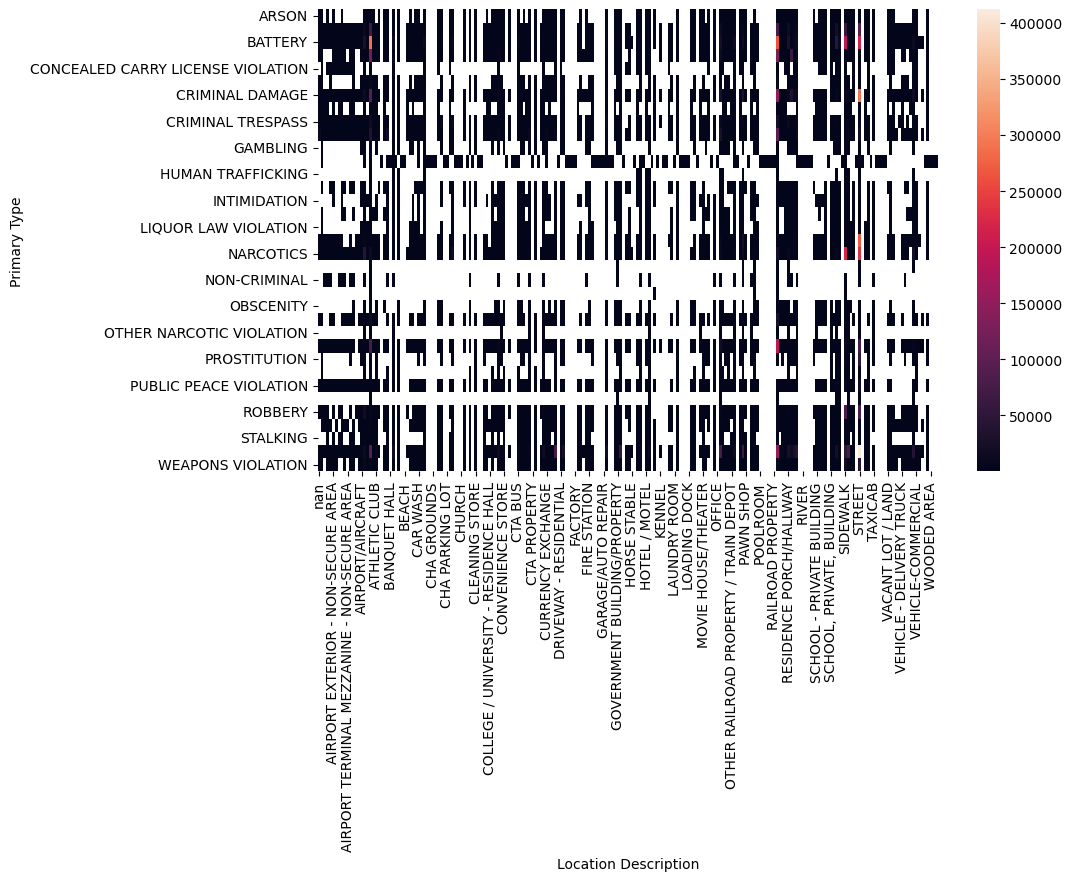

In [191]:
# Show the heatmap
plt.figure(figsize=(10,6))
ax = sns.heatmap(crosstab)
plt.show()

### 6a. Bring in daily Covid cases data from the City of Chicago data portal and load into your data lake or Hive

In [236]:
covid = spark.read \
    .option("quote", "\"")  \
    .option("escape", "\"") \
    .option("ignoreLeadingWhiteSpace",True) \
    .csv("gs://bdp-hw-su/notebooks/data/COVID-19_Daily_Cases__Deaths__and_Hospitalizations-3.csv",inferSchema=True, header=True)

In [237]:
covid = covid.select('Date', 'Cases - Total', 'Deaths - Total')

In [238]:
import pandas as pd
from pyspark.sql import Row
start_date = "01/01/2020"
end_date = "02/29/2020"
date_range = pd.date_range(start=start_date, end=end_date, freq='D').strftime('%m/%d/%Y').tolist()

# Create a list of Row objects for each date
rows = [Row(Date=date, Cases_Total=0, Deaths_Total=0) for date in date_range]
schema = ["Date", "Cases - Total", "Deaths - Total"]
jan_feb_df = spark.createDataFrame(rows, schema=schema)

# Union the existing DataFrame with the new DataFrame containing January and February data
covid = jan_feb_df.union(covid)

# Show the updated DataFrame
covid.show()

+----------+-------------+--------------+
|      Date|Cases - Total|Deaths - Total|
+----------+-------------+--------------+
|01/01/2020|            0|             0|
|01/02/2020|            0|             0|
|01/03/2020|            0|             0|
|01/04/2020|            0|             0|
|01/05/2020|            0|             0|
|01/06/2020|            0|             0|
|01/07/2020|            0|             0|
|01/08/2020|            0|             0|
|01/09/2020|            0|             0|
|01/10/2020|            0|             0|
|01/11/2020|            0|             0|
|01/12/2020|            0|             0|
|01/13/2020|            0|             0|
|01/14/2020|            0|             0|
|01/15/2020|            0|             0|
|01/16/2020|            0|             0|
|01/17/2020|            0|             0|
|01/18/2020|            0|             0|
|01/19/2020|            0|             0|
|01/20/2020|            0|             0|
+----------+-------------+--------

In [239]:
covid.dtypes

[('Date', 'string'), ('Cases - Total', 'string'), ('Deaths - Total', 'bigint')]

In [245]:
covid = covid.withColumn('Date', F.to_date('Date', 'MM/dd/yyyy'))
covid = covid.withColumn('Cases - Total', F.col('Cases - Total').cast('int'))

In [246]:
covid.dtypes

[('Date', 'date'), ('Cases - Total', 'int'), ('Deaths - Total', 'bigint')]

In [247]:
covid = covid.orderBy('Date')

In [252]:
covid.show()

+----------+-------------+--------------+
|      Date|Cases - Total|Deaths - Total|
+----------+-------------+--------------+
|2020-01-01|            0|             0|
|2020-01-02|            0|             0|
|2020-01-03|            0|             0|
|2020-01-04|            0|             0|
|2020-01-05|            0|             0|
|2020-01-06|            0|             0|
|2020-01-07|            0|             0|
|2020-01-08|            0|             0|
|2020-01-09|            0|             0|
|2020-01-10|            0|             0|
|2020-01-11|            0|             0|
|2020-01-12|            0|             0|
|2020-01-13|            0|             0|
|2020-01-14|            0|             0|
|2020-01-15|            0|             0|
|2020-01-16|            0|             0|
|2020-01-17|            0|             0|
|2020-01-18|            0|             0|
|2020-01-19|            0|             0|
|2020-01-20|            0|             0|
+----------+-------------+--------

In [253]:
covid.dtypes

[('Date', 'date'), ('Cases - Total', 'int'), ('Deaths - Total', 'bigint')]

### 6b. Create summarized daily total counts of the daily crime data **by crime type**

In [283]:
df_covid = df1.groupBy('Date','Primary Type').count().orderBy('Date')

In [284]:
df_covid.show()

+----------+--------------------+-----+
|      Date|        Primary Type|count|
+----------+--------------------+-----+
|2001-01-01| MOTOR VEHICLE THEFT|    4|
|2001-01-01|       OTHER OFFENSE|    6|
|2001-01-01|CRIMINAL SEXUAL A...|    3|
|2001-01-01|         SEX OFFENSE|   56|
|2001-01-01|             BATTERY|    2|
|2001-01-01|  DECEPTIVE PRACTICE|   35|
|2001-01-01|            HOMICIDE|    2|
|2001-01-01|               THEFT|  145|
|2001-01-01| CRIM SEXUAL ASSAULT|   29|
|2001-01-01|OFFENSE INVOLVING...|   79|
|2001-01-02|   CRIMINAL TRESPASS|    2|
|2001-01-02| MOTOR VEHICLE THEFT|    2|
|2001-01-02|       OTHER OFFENSE|    1|
|2001-01-02|  DECEPTIVE PRACTICE|    2|
|2001-01-02|               THEFT|   10|
|2001-01-03|   CRIMINAL TRESPASS|    4|
|2001-01-03| MOTOR VEHICLE THEFT|    3|
|2001-01-03|               THEFT|    5|
|2001-01-03|         SEX OFFENSE|    1|
|2001-01-03|             BATTERY|    2|
+----------+--------------------+-----+
only showing top 20 rows



### 6c. Join daily total covid cases and death data with daily chicago crimes data starting Jan 2020.

In [285]:
df_covid = df_covid.join(covid,on='Date')

In [286]:
df_covid.show()

+----------+--------------------+-----+-------------+--------------+
|      Date|        Primary Type|count|Cases - Total|Deaths - Total|
+----------+--------------------+-----+-------------+--------------+
|2023-01-09|               THEFT|  139|          493|             0|
|2020-10-25|OFFENSE INVOLVING...|    7|          525|            10|
|2021-11-05|OFFENSE INVOLVING...|    8|          473|             3|
|2020-12-12|  DECEPTIVE PRACTICE|   62|          915|            21|
|2021-03-03|           NARCOTICS|   42|          336|             5|
|2022-03-05|  DECEPTIVE PRACTICE|   28|           93|             1|
|2021-06-29|           NARCOTICS|   13|           56|             2|
|2022-07-21|               THEFT|  162|          970|             0|
|2021-12-01|CRIMINAL SEXUAL A...|    4|         null|             6|
|2020-03-05|           NARCOTICS|   39|            1|             0|
|2021-01-25|               THEFT|   77|          856|            11|
|2021-02-14|       OTHER OFFENSE| 

### 6d. Perform a thorough analysis in PySpark on how Covid-19 has impacted various types of crimes compared to previous years.

In [287]:
df_covid = df_covid.orderBy('Date')

In [288]:
df_covid.show()

+----------+--------------------+-----+-------------+--------------+
|      Date|        Primary Type|count|Cases - Total|Deaths - Total|
+----------+--------------------+-----+-------------+--------------+
|2020-01-01| MOTOR VEHICLE THEFT|   17|            0|             0|
|2020-01-01|LIQUOR LAW VIOLATION|    1|            0|             0|
|2020-01-01|   CRIMINAL TRESPASS|   20|            0|             0|
|2020-01-01|OFFENSE INVOLVING...|   40|            0|             0|
|2020-01-01|     CRIMINAL DAMAGE|  104|            0|             0|
|2020-01-01| CRIM SEXUAL ASSAULT|    8|            0|             0|
|2020-01-01|             ASSAULT|   58|            0|             0|
|2020-01-01|             BATTERY|  238|            0|             0|
|2020-01-01|         SEX OFFENSE|   19|            0|             0|
|2020-01-01|CRIMINAL SEXUAL A...|   23|            0|             0|
|2020-01-01|PUBLIC PEACE VIOL...|    3|            0|             0|
|2020-01-01|CONCEALED CARRY L...| 

In [293]:
df_prev3yrs = df1.filter(F.col('Year').between(2017,2019)).groupBy('Date','Primary Type').count().orderBy('Date')

In [298]:
df_prev3yrs = df_prev3yrs.select("*", F.lit(0).alias('Cases - Total'), F.lit(0).alias('Deaths - Total'))


In [299]:
df_prev3yrs.show()

+----------+--------------------+-----+-------------+--------------+
|      Date|        Primary Type|count|Cases - Total|Deaths - Total|
+----------+--------------------+-----+-------------+--------------+
|2017-01-01|INTERFERENCE WITH...|    3|            0|             0|
|2017-01-01|     CRIMINAL DAMAGE|  116|            0|             0|
|2017-01-01|   CRIMINAL TRESPASS|   15|            0|             0|
|2017-01-01|             BATTERY|  207|            0|             0|
|2017-01-01|          KIDNAPPING|    1|            0|             0|
|2017-01-01|        INTIMIDATION|    1|            0|             0|
|2017-01-01|       OTHER OFFENSE|   78|            0|             0|
|2017-01-01|           OBSCENITY|    1|            0|             0|
|2017-01-01|   WEAPONS VIOLATION|    9|            0|             0|
|2017-01-01|               THEFT|  187|            0|             0|
|2017-01-01|   HUMAN TRAFFICKING|    1|            0|             0|
|2017-01-01|            BURGLARY| 

In [300]:
df_since2017 = df_prev3yrs.union(df_covid)

In [306]:
avgs_since17 = df_since2017.groupBy('Date').avg('count', 'Cases - Total', 'Deaths - Total')

In [307]:
avgs_since17 = avgs_since17.toPandas()

In [315]:
avgs_since17 = avgs_since17.rename(columns ={'Date': 'Date', 'avg(count)': 'avg_crime_cnt',
                    'avg(Cases - Total)': 'cases', 'avg(Deaths - Total)': 'deaths'})

In [318]:
avgs_since17 = avgs_since17.sort_values('Date')

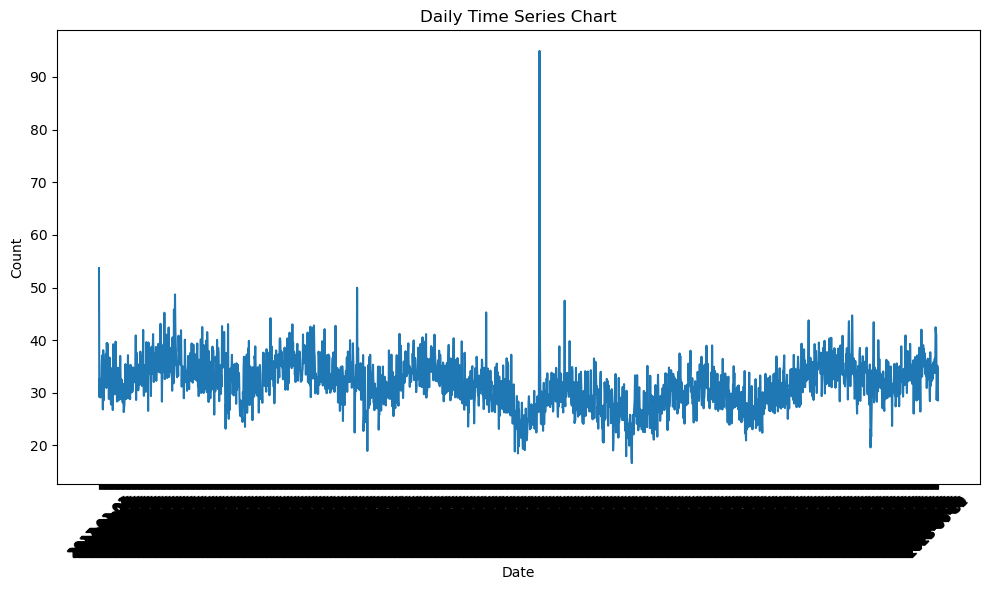

In [328]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(avgs_since17['Date'], avgs_since17['avg_crime_cnt'], linestyle='-', marker='')  # Set marker to empty string
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Daily Time Series Chart")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

There is not a significant change between pre-2020 and post-2020. However, there is a slight increase in the year 2022.

In [331]:
avgs_since17.sort_values('avg_crime_cnt', ascending=False).head(1)

,Date,avg_crime_cnt,cases,deaths
805,2020-05-31,94.95,121.0,22.0


The day with the most crimes is May 31, 2020, at the height of the BLM movement.

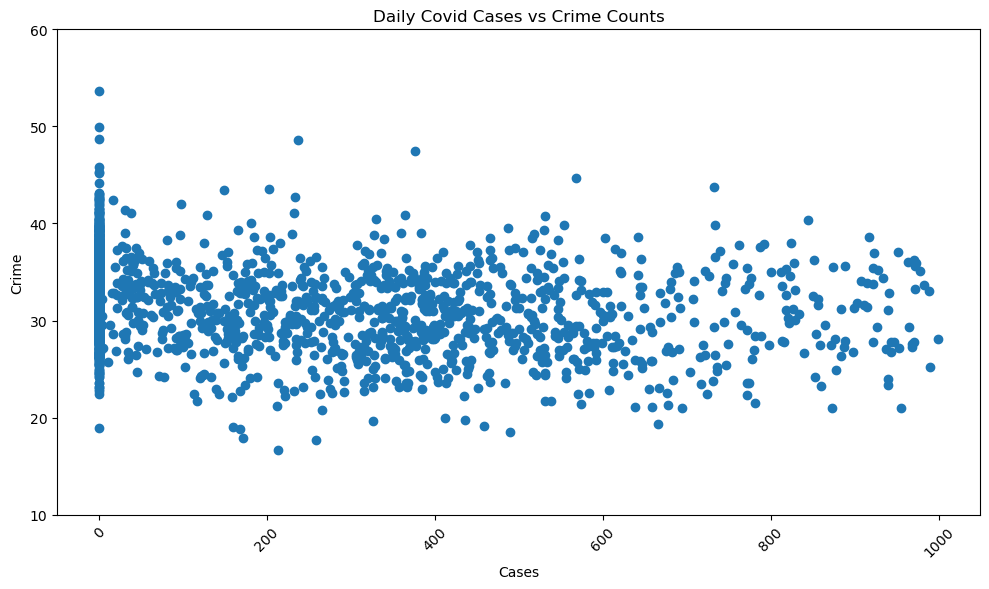

In [325]:
# Plot the time series chart
plt.figure(figsize=(10, 6))
plt.scatter(avgs_since17['cases'], avgs_since17['avg_crime_cnt'], marker='o')
plt.xlabel("Cases")
plt.ylabel("Crime")
plt.title("Daily Covid Cases vs Crime Counts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylim(10,60)
plt.show()

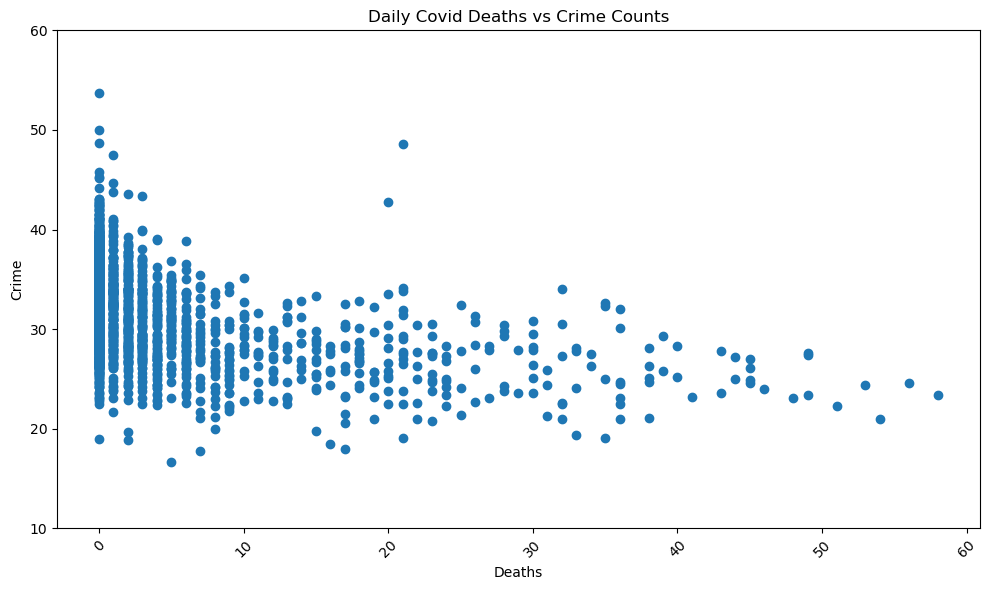

In [327]:
# Plot the time series chart
plt.figure(figsize=(10, 6))
plt.scatter(avgs_since17['deaths'], avgs_since17['avg_crime_cnt'], marker='o')
plt.xlabel("Deaths")
plt.ylabel("Crime")
plt.title("Daily Covid Deaths vs Crime Counts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylim(10,60)
plt.show()

There isn't a strong correlation between number of cases and the number of crimes on a given day. However, there is a slight trend between number of deaths and number of crimes - number of crimes tend to decrease when number of death increases.

In [334]:
top5 = df1.filter(F.col('Primary Type').isin("THEFT", "BATTERY", "CRIMINAL DAMAGE", "NARCOTICS", "ASSAULT") & F.col('Year').between(2017,2022))  \
                 .groupBy("Year", 'Primary Type').agg(F.count("*").alias('Count')).toPandas()

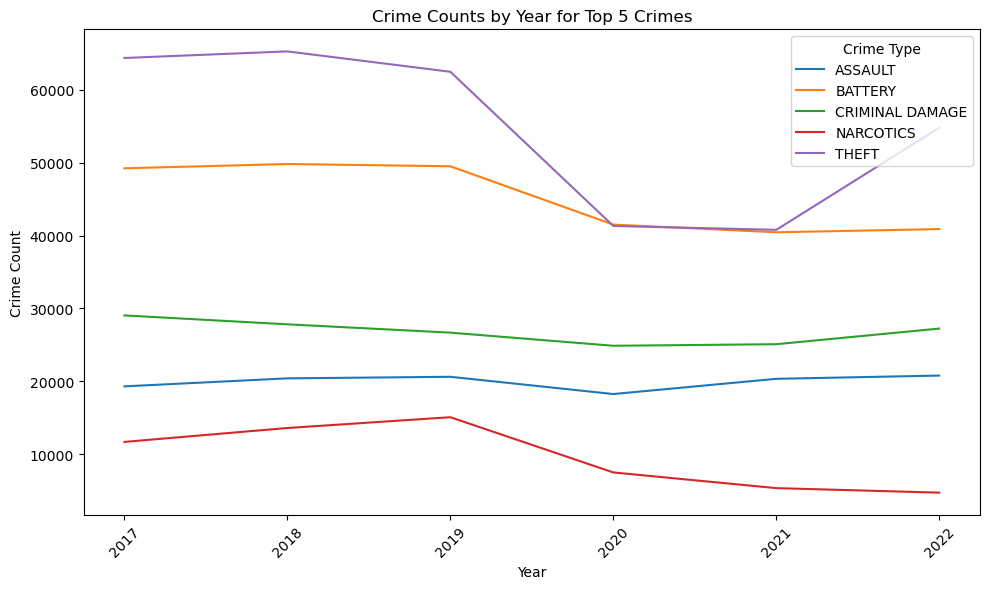

In [336]:
# Pivot the data to get the crimes as columns and years as rows
pivoted_df = top5.pivot(index='Year', columns='Primary Type', values='Count')

# Plot the line chart
pivoted_df.plot(kind='line', figsize=(10, 6))
plt.xlabel("Year")
plt.ylabel("Crime Count")
plt.title("Crime Counts by Year for Top 5 Crimes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Crime Type")
plt.show()

Here is a line plot of number of top 5 Crime over time for the past 6 years. We can see that all 5 crimes see varying degrees of decrease from 2019 to 2020, with Theft dropping most significantly. Pre-covid we see a constant rise in narcotics, but it also sees a drop in the year 2020. Also, there is a bounce back in 2022 for theft and criminal damage. This is largely due to the fear of cross-contamination and enforced stay-at-home policies.